In [16]:
%%capture
%pip install yfinance

In [17]:
import yfinance as yf

ticker = yf.Ticker("PETR4.SA")
df = ticker.history(period="2y")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-11 00:00:00-03:00,37.009998,37.090000,36.680000,36.830002,16624300,0.0,0.0
2025-02-12 00:00:00-03:00,36.650002,36.750000,36.110001,36.279999,37364500,0.0,0.0
2025-02-13 00:00:00-03:00,36.200001,36.330002,36.020000,36.320000,15351300,0.0,0.0
2025-02-14 00:00:00-03:00,36.439999,37.580002,36.400002,37.439999,40322000,0.0,0.0
2025-02-17 00:00:00-03:00,37.639999,37.919998,37.470001,37.810001,17567300,0.0,0.0


In [18]:
def compute_traders_eden(df):
    df = df.copy()
    df["MMA8"] = df["Close"].rolling(window=8).mean()
    df["MME80"] = df["Close"].ewm(span=80, min_periods=80).mean()
    
    df["is_bullish"] = (
        (df["MMA8"] > df["MMA8"].shift(1)) &
        (df["MME80"] > df["MME80"].shift(1)) &
        (df["Close"] > df["MMA8"]) &
        (df["Close"] > df["MME80"])
    )
    df["is_bearish"] = (
        (df["MMA8"] < df["MMA8"].shift(1)) &
        (df["MME80"] < df["MME80"].shift(1)) &
        (df["Close"] < df["MMA8"]) &
        (df["Close"] < df["MME80"])
    )
    return df

In [19]:
df = compute_traders_eden(df)
df = df[["Close", "is_bullish", "is_bearish"]]

df.tail()

,Close,is_bullish,is_bearish
Date,,,
2025-02-11 00:00:00-03:00,36.830002,False,False
2025-02-12 00:00:00-03:00,36.279999,False,False
2025-02-13 00:00:00-03:00,36.320000,False,False
2025-02-14 00:00:00-03:00,37.439999,True,False
2025-02-17 00:00:00-03:00,37.810001,True,False


In [20]:
df["pct_change"] = df["Close"].pct_change()
df.dropna(inplace=True)
df.tail()

,Close,is_bullish,is_bearish,pct_change
Date,,,,
2025-02-11 00:00:00-03:00,36.830002,False,False,0.000000
2025-02-12 00:00:00-03:00,36.279999,False,False,-0.014934
2025-02-13 00:00:00-03:00,36.320000,False,False,0.001103
2025-02-14 00:00:00-03:00,37.439999,True,False,0.030837
2025-02-17 00:00:00-03:00,37.810001,True,False,0.009883


In [21]:
import numpy as np

df["position"] = np.where(
    df["is_bullish"] & (~df["is_bullish"].shift(1).fillna(False)), 
    1, 
    np.where(
        df["is_bearish"] & (~df["is_bearish"].shift(1).fillna(False)), 
        -1, 
        0
    )
)

df["position"] = df["position"].shift(1)
df.dropna(inplace=True)

df.tail()

/var/folders/vl/lkdr17d56_n33hmm9609cgmr0000gn/T/ipykernel_42218/1169441942.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_bullish"] & (~df["is_bullish"].shift(1).fillna(False)),
/var/folders/vl/lkdr17d56_n33hmm9609cgmr0000gn/T/ipykernel_42218/1169441942.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_bearish"] & (~df["is_bearish"].shift(1).fillna(False)),


,Close,is_bullish,is_bearish,pct_change,position
Date,,,,,
2025-02-11 00:00:00-03:00,36.830002,False,False,0.000000,0.0
2025-02-12 00:00:00-03:00,36.279999,False,False,-0.014934,0.0
2025-02-13 00:00:00-03:00,36.320000,False,False,0.001103,0.0
2025-02-14 00:00:00-03:00,37.439999,True,False,0.030837,0.0
2025-02-17 00:00:00-03:00,37.810001,True,False,0.009883,1.0


<Axes: xlabel='Date'>

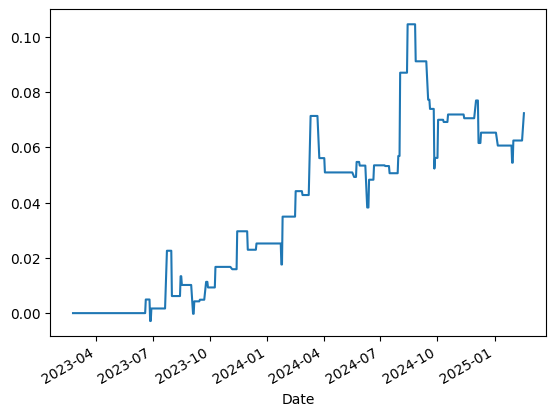

In [22]:
df["result"] = df["pct_change"] * df["position"]
df["cum_result"] = df["result"].cumsum()
df["cum_result"].plot()

In [23]:
trades = df[df["position"] != 0]
trades

,Close,is_bullish,is_bearish,pct_change,position,result,cum_result
Date,,,,,,,
2023-06-20 00:00:00-03:00,23.143135,True,False,0.004931,1.0,0.004931,0.004931
2023-06-27 00:00:00-03:00,23.165850,False,False,-0.007782,1.0,-0.007782,-0.002851
2023-06-29 00:00:00-03:00,23.491383,True,False,0.004532,1.0,0.004532,0.001681
2023-07-24 00:00:00-03:00,22.938732,True,False,0.020889,1.0,0.020889,0.022570
2023-08-01 00:00:00-03:00,23.165850,True,False,-0.016393,1.0,-0.016393,0.006177
2023-08-15 00:00:00-03:00,23.362686,False,False,0.007180,1.0,0.007180,0.013357
2023-08-17 00:00:00-03:00,23.801777,True,False,-0.003171,1.0,-0.003171,0.010187
2023-09-04 00:00:00-03:00,25.377092,False,False,-0.010420,1.0,-0.010420,-0.000233
2023-09-06 00:00:00-03:00,26.343765,True,False,0.004495,1.0,0.004495,0.004262


In [25]:
def strategy_stats(trades):
  winning_trades = trades[trades['result'] > 0]['result'].sum()
  losing_trades = abs(trades[trades['result'] < 0]['result'].sum())

  print(f"Total trades: {len(trades)}")
  print(f"Total profit: {trades['result'].sum():.2%}")
  print(f"Win rate: {len(trades[trades['result'] > 0]) / len(trades):.2%}")
  print(f"Profit factor: {winning_trades / losing_trades:.2f}")
  print(f"Average winning trade: {winning_trades / len(trades[trades['result'] > 0]):.2%}")
  print(f"Average losing trade: {losing_trades / len(trades[trades['result'] < 0]):.2%}")

In [26]:
strategy_stats(trades)

Total trades: 51
Total profit: 7.23%
Win rate: 50.98%
Profit factor: 1.41
Average winning trade: 0.96%
Average losing trade: 0.71%
